In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import math
from scipy import stats
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as sm

In [2]:
df = pd.read_csv('heart.csv').set_index('HeartDisease').reset_index().rename(columns={'FastingBS':'FastingBS_Above120'})
df.head()

,HeartDisease,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS_Above120,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up
1,1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat
2,0,37,M,ATA,130,283,0,ST,98,N,0.0,Up
3,1,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat
4,0,54,M,NAP,150,195,0,Normal,122,N,0.0,Up


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HeartDisease        918 non-null    int64  
 1   Age                 918 non-null    int64  
 2   Sex                 918 non-null    object 
 3   ChestPainType       918 non-null    object 
 4   RestingBP           918 non-null    int64  
 5   Cholesterol         918 non-null    int64  
 6   FastingBS_Above120  918 non-null    int64  
 7   RestingECG          918 non-null    object 
 8   MaxHR               918 non-null    int64  
 9   ExerciseAngina      918 non-null    object 
 10  Oldpeak             918 non-null    float64
 11  ST_Slope            918 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


# CATEGORICAL FEATURES HISTOGRAM

In [4]:
def histogram(data, columns, equal_scales=True, title='Histogram'):
    fig, axs = plt.subplots(1, len(columns), figsize=(20, 7))
    y_lim =  data[columns].apply(pd.value_counts).max().max()*1.05
    i = 0
    for col in columns:
        g = sns.histplot(data=data, x=col, ax=axs[i], multiple='dodge', shrink=0.9)
        i+=1
        if(equal_scales):
            g.set(ylim=(0,y_lim))
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()

def separate_histogram(data, columns, equal_scales=True, title='Layered Histogram split by HeartDisease', kde=False):
    fig, axs = plt.subplots(1, len(columns), figsize=(20, 7))
    y_lim = 0
    for val in data['HeartDisease'].unique():
        y_lim = max(y_lim, data[data['HeartDisease']==val][columns].apply(pd.value_counts).max().max()) * 1.05
    i = 0
    for col in columns:
        g = sns.histplot(data=data, x=col, ax=axs[i], hue='HeartDisease', multiple='layer', shrink=0.9, kde=kde, line_kws={'lw': 4})
        i+=1
        if(equal_scales):
            g.set(ylim=(0,y_lim))
        
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()

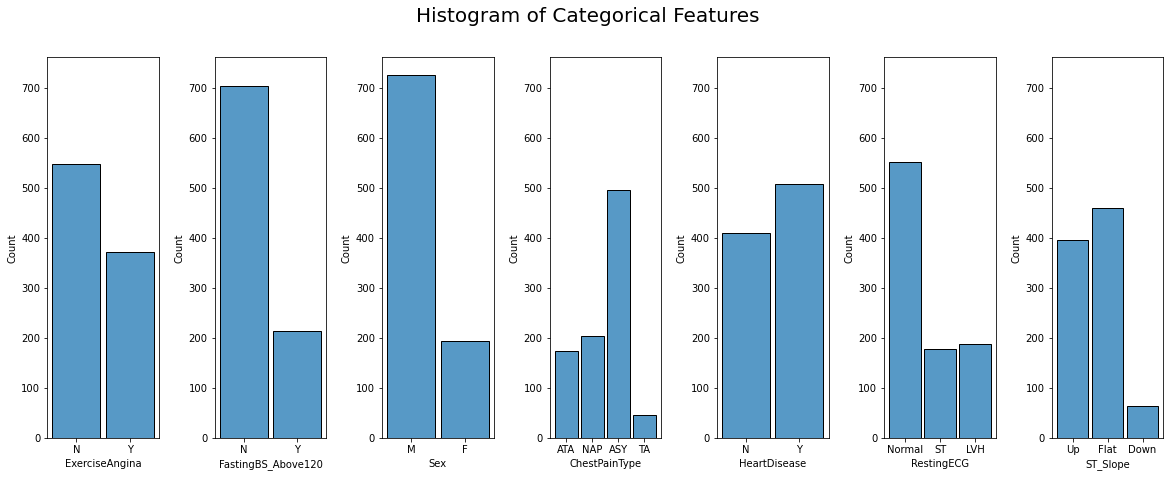

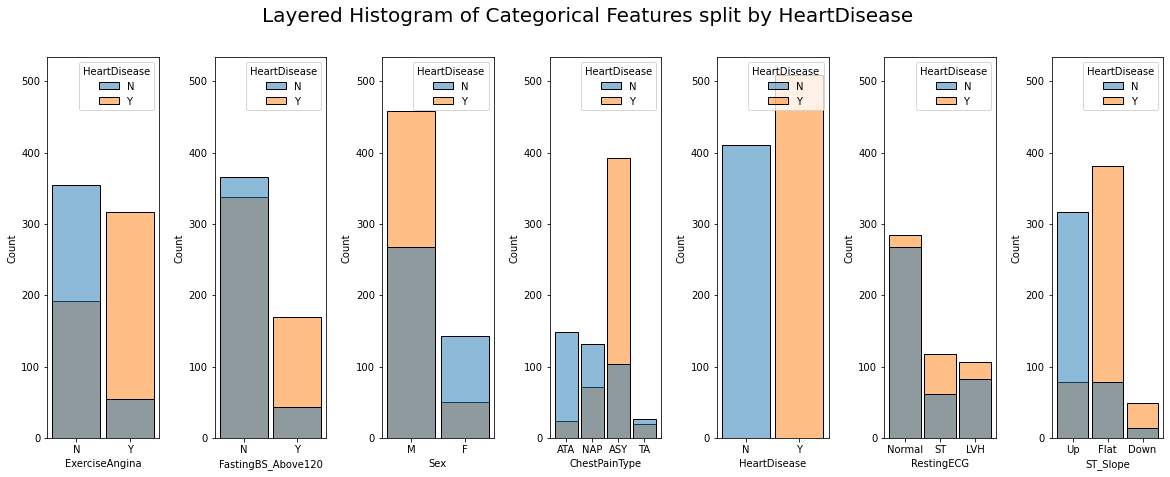

In [5]:
# Categorical columns (non-numeric OR only 2 values)
ohe_cols = (df.dtypes=='object')
ohe_cols = ohe_cols[ohe_cols].index.tolist()
bin_cols = (df.nunique()==2)
bin_cols = bin_cols[bin_cols].index.tolist()
histogram(df.replace({0: 'N', 1:'Y'}), set(ohe_cols+bin_cols), title='Histogram of Categorical Features')
separate_histogram(df.replace({0: 'N', 1:'Y'}), list(set(ohe_cols+bin_cols)), title='Layered Histogram of Categorical Features split by HeartDisease')

Sex and FastingBS_above120 are clearly imbalanced.

Certain others seem somewhat imbalaced:
- RestingECG (Normal $\approx$ ST + LVH)
- ST_Slope (Down largly under-represented)
- ChestPainType (TA largly under-represented)

# CONTINUOUS FEATURES BOXPLOT

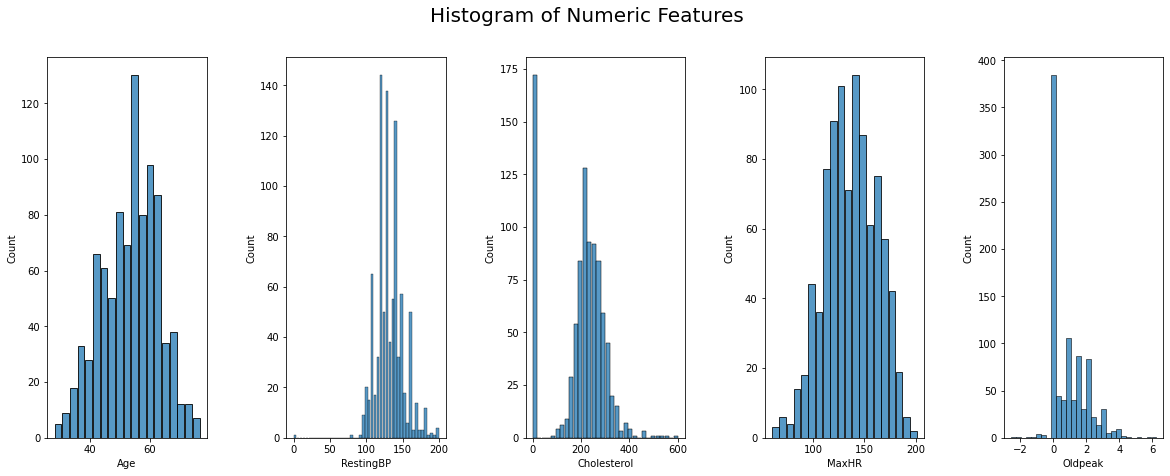

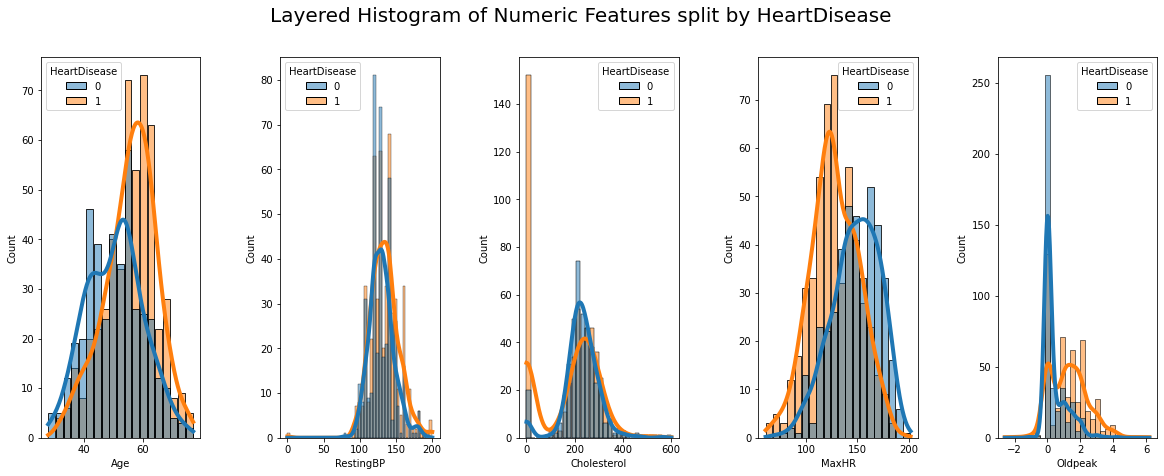

In [6]:
non_bin =df.drop(columns=ohe_cols+bin_cols+['HeartDisease'])
selection = non_bin.columns.tolist()
histogram(df, selection, equal_scales=False, title='Histogram of Numeric Features')
separate_histogram(df, selection, equal_scales=False, kde=True, title = 'Layered Histogram of Numeric Features split by HeartDisease')

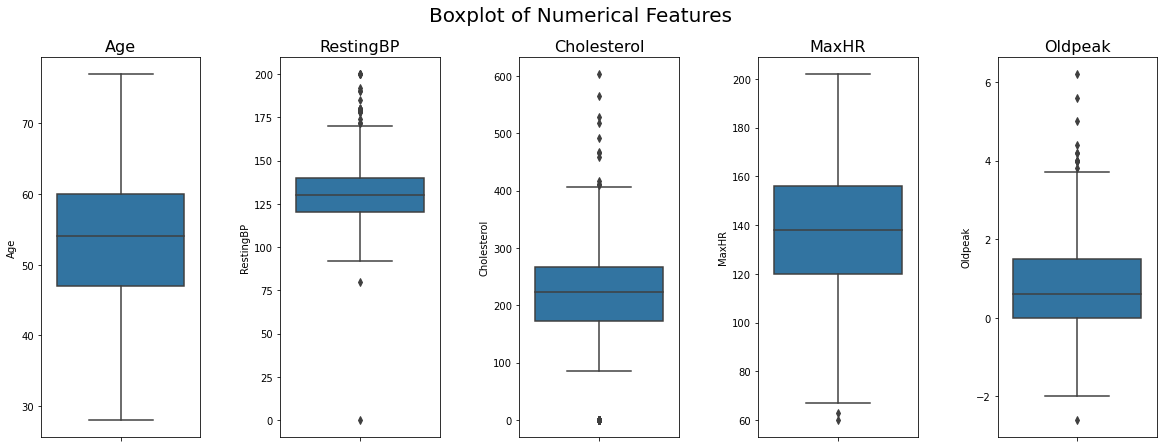

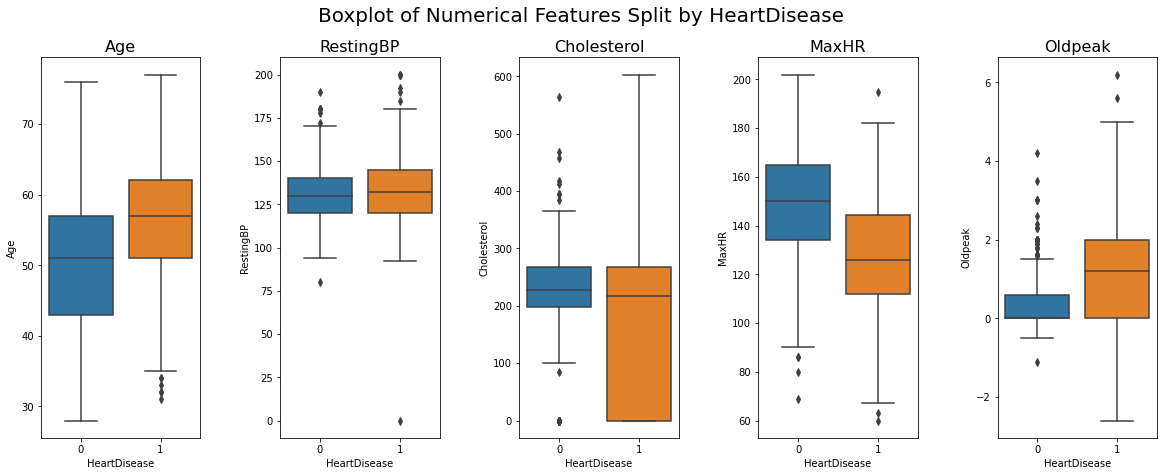

In [7]:
def boxplot(data, columns,  title='Boxplot of Numerical Features'):

    fig, axs = plt.subplots(1, len(selection), figsize=(20, 7))
    i=0
    for col in columns:
        g= sns.boxplot(data=data, y=col, ax=axs[i])
        axs[i].set_title(col, fontsize=16)
        i+=1
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()

def separate_boxplot(data, columns, title='Boxplot of Numerical Features Split by HeartDisease'):
    fig, axs = plt.subplots(1, len(selection), figsize=(20, 7))
    i=0
    for col in columns:
        g= sns.boxplot(data=data,x='HeartDisease', y=col, ax=axs[i])
        axs[i].set_title(col, fontsize=16)
        i+=1
    plt.suptitle(title, fontsize=20)
    plt.subplots_adjust(hspace = 0.5, wspace=0.5)
    plt.show()
    
boxplot(df, selection)
separate_boxplot(df, selection)

RestingBP and Cholesterol = 0 error: remove  
Outliers outside IQR: remove?

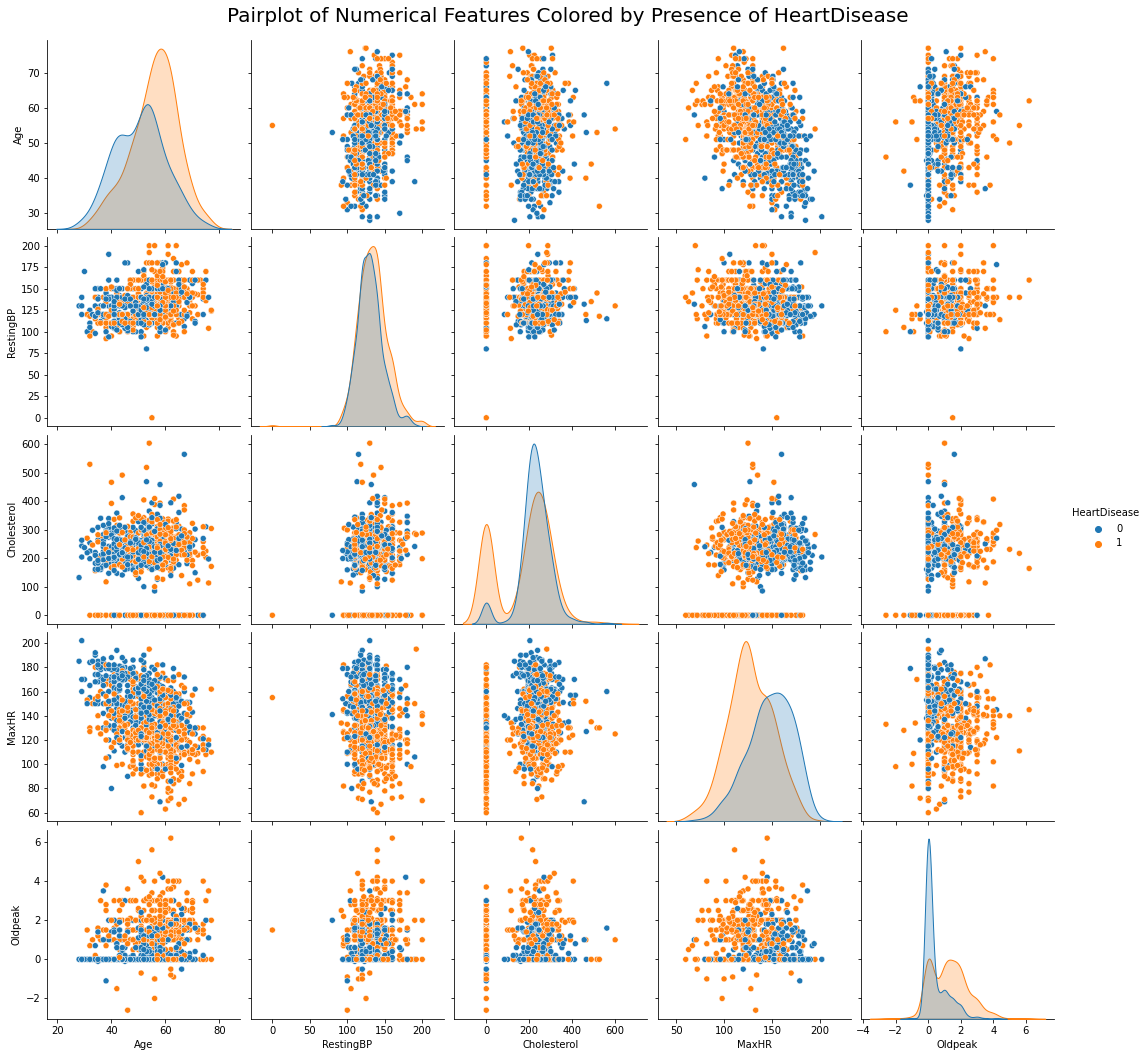

In [8]:
def pairplot(data, columns, title='Pairplot of Numerical Features Colored by Presence of HeartDisease'):
    pairplot = sns.pairplot(data[columns], hue="HeartDisease", height=3)
    pairplot.fig.subplots_adjust(top=0.95)
    pairplot.fig.suptitle(title, fontsize=20, fontweight=2)
pairplot(df, selection+['HeartDisease'])

# PREPARE DATASET: 
#### 1. Remove errors
    - Cholesteral and RestingBP = 0 is impossible

In [9]:
dropped = df[(df['Cholesterol'] == 0) & (df['Cholesterol'] == 0)]
cleaned = df.drop(dropped.index)
print('Dropped {} rows.\nKept {} rows.'.format(len(dropped), len(cleaned)))

Dropped 172 rows.
Kept 746 rows.


#### 2. OHE and Binary to (0, 1):
    - Sex (M or F), ExerciseAngine (N or Y), FastingBS_120+ (0 or 1) are binary -> 0, 1
    - ChestPainType, ST_Slope and RestingECG are categorical -> One Hot Encoding
   

In [10]:
prepared = cleaned.copy(deep=True)

bin_cols = ['Sex', 'ExerciseAngina', 'FastingBS_Above120']
prepared[bin_cols] = prepared[bin_cols].replace({'M':0, 'F':1, 'N' : 0, 'Y':1})

ohe_cols = ['ChestPainType','ST_Slope', 'RestingECG']
prepared = pd.get_dummies(prepared, columns=ohe_cols, prefix_sep='__')

#### 3. Standardize continuous columns
    - Age, RestingBP, Cholesterol, MaxHR, OldPeak

In [11]:
continuous_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
prepared[continuous_cols] = StandardScaler().fit_transform(prepared[continuous_cols])

#### 4. Remove outliers
    Outside of IQR, after standardization: <= -3 and >= 3

In [33]:
prepared = prepared[(prepared.abs()<3).all(axis=1)]
print('Kept {} rows.'.format(len(prepared)))

Kept 727 rows.


In [34]:
prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 0 to 917
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HeartDisease        727 non-null    int64  
 1   Age                 727 non-null    float64
 2   Sex                 727 non-null    int64  
 3   RestingBP           727 non-null    float64
 4   Cholesterol         727 non-null    float64
 5   FastingBS_Above120  727 non-null    int64  
 6   MaxHR               727 non-null    float64
 7   ExerciseAngina      727 non-null    int64  
 8   Oldpeak             727 non-null    float64
 9   ChestPainType__ASY  727 non-null    uint8  
 10  ChestPainType__ATA  727 non-null    uint8  
 11  ChestPainType__NAP  727 non-null    uint8  
 12  ChestPainType__TA   727 non-null    uint8  
 13  ST_Slope__Down      727 non-null    uint8  
 14  ST_Slope__Flat      727 non-null    uint8  
 15  ST_Slope__Up        727 non-null    uint8  
 16  RestingE

# Feature Selection:
### Forward Selection

In [35]:
significance_level = 0.01
def get_pvals(data, formula, columns):
    pvals = []
    for feat in columns:
        model = sm.logit(formula=formula+feat, data=data).fit(disp=0)
        pvals.append( [feat, model.pvalues[feat]])
    return pd.DataFrame(pvals, columns=['feature', 'pval'])

forward_formula = 'HeartDisease ~ '
columns = prepared.drop(columns=['HeartDisease']).columns.tolist()
while(True):
    best = get_pvals(prepared, forward_formula, columns=columns).sort_values('pval').iloc[0]
    if(best['pval']>significance_level):
        break
    forward_formula =forward_formula + best['feature'] +' + '
    columns.remove(best['feature'])
forward_formula = forward_formula[:-3]

print('Forward selection gives us the formula:\n\t'+forward_formula)
sm.logit(formula=forward_formula, data=prepared).fit(disp=0).summary()

Forward selection gives us the formula:
	HeartDisease ~ ST_Slope__Up + ChestPainType__ASY + Sex + ExerciseAngina + Age + Oldpeak


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:                  727
Model:                          Logit   Df Residuals:                      720
Method:                           MLE   Df Model:                            6
Date:                Sun, 20 Mar 2022   Pseudo R-squ.:                  0.5240
Time:                        20:16:52   Log-Likelihood:                -239.24
converged:                       True   LL-Null:                       -502.65
Covariance Type:            nonrobust   LLR p-value:                1.403e-110
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1487      0.217      0.685      0.493      -0.277       0.574
ST_Slope__Up          -2.4629      0.270     -9.135      0.000      -2.991      -1.935
ChestPainType__ASY     1.6175      0.246      6.565      0.000       1.135       2.100
Sex                   -1.7471      0.300     -5.830      0.000      -2.334      -1.160
ExerciseAngina         0.9402      0.261      3.608      0.000       0.429       1.451
Age                    0.3963      0.126      3.140      0.002       0.149       0.644
Oldpeak                0.4095      0.151      2.713      0.007       0.114       0.705
======================================================================================
"""

### Backwards Selection

In [36]:
significance_level = 0.01
columns = prepared.drop(columns='HeartDisease').columns.tolist()
while(True):
    backwards_formula = 'HeartDisease ~ '+' + '.join(columns)
    model = sm.logit(formula=backwards_formula, data=prepared).fit_regularized(disp=0)
    df = pd.DataFrame(model.pvalues).sort_values(0, ascending=False).drop('Intercept')
    if(df.iloc[0, 0]<significance_level):
        break
    columns.remove(df.iloc[0].name)
    
print('Backwards selection gives us the formula:\n\t'+backwards_formula)
sm.logit(formula=backwards_formula, data=prepared).fit(disp=0).summary()

Backwards selection gives us the formula:
	HeartDisease ~ Age + Sex + ExerciseAngina + Oldpeak + ChestPainType__ASY + ST_Slope__Up


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:                  727
Model:                          Logit   Df Residuals:                      720
Method:                           MLE   Df Model:                            6
Date:                Sun, 20 Mar 2022   Pseudo R-squ.:                  0.5240
Time:                        20:16:53   Log-Likelihood:                -239.24
converged:                       True   LL-Null:                       -502.65
Covariance Type:            nonrobust   LLR p-value:                1.403e-110
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1487      0.217      0.685      0.493      -0.277       0.574
Age                    0.3963      0.126      3.140      0.002       0.149       0.644
Sex                   -1.7471      0.300     -5.830      0.000      -2.334      -1.160
ExerciseAngina         0.9402      0.261      3.608      0.000       0.429       1.451
Oldpeak                0.4095      0.151      2.713      0.007       0.114       0.705
ChestPainType__ASY     1.6175      0.246      6.565      0.000       1.135       2.100
ST_Slope__Up          -2.4629      0.270     -9.135      0.000      -2.991      -1.935
======================================================================================
"""

['Age', 'Sex', 'ExerciseAngina', 'Oldpeak', 'ChestPainType__ASY', 'ST_Slope__Up']


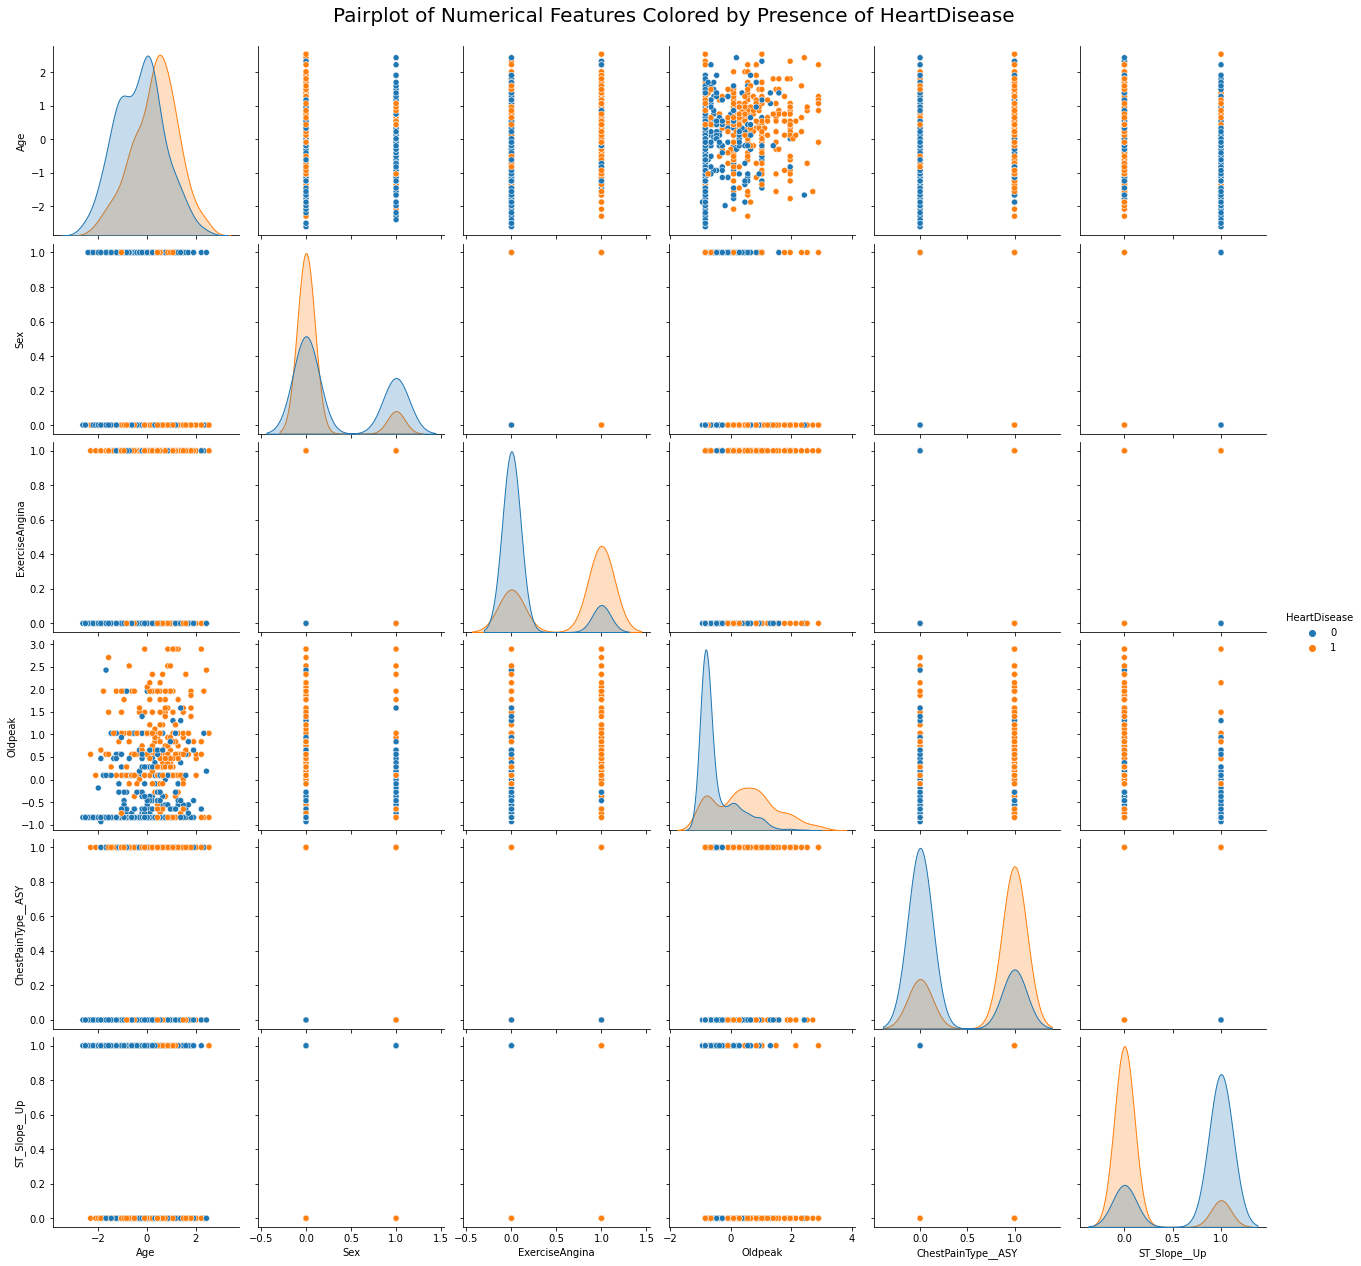

In [37]:
selected_features = backwards_formula.split(' ~ ')[1].split(' + ')
print(selected_features)
pairplot(prepared, selected_features+['HeartDisease'])

# Testing (non-) independence

### 2 Tailed T-Test:
- Compare population means
- Assume no equal variances between population (look into this)
- $H_{0}$ : $\mu_{i, heartdisease} = \mu_{i, no\_heartdisease}$
- $H_{a}$ : $\mu_{i, heartdisease} \neq \mu_{i, no\_heartdisease}$  
where i $\in$ ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [32]:
significantly_different = []

def ind_t_test(column, group, data):

    group0 = data[data[group]==0][column]
    group1 = data[data[group]==1][column]
    
    print(column,':')
    t_stat, p_val = stats.ttest_ind(group0, group1, equal_var=False)
    reject = p_val<significance_level
    print('\t-{} {} vs {} {} => p-value: {:.2E}, t statistic: {:.5f}'.format(group, 0, group, 1, p_val, t_stat))
    if reject:
        print('\t {:.2E} {} {}. H0 is {}. Both populations are {} significantly different'.format(p_val, '<', significance_level, 'rejected', ''))
    else:
        print('\t {:.2E} {} {}. H0 is {}. Both populations are {} significantly different.'.format(p_val, '>', significance_level, 'accepted', 'not'))
    print()
    return reject

significance_level = 0.05
for col in continuous_cols:
    if(ind_t_test(col, 'HeartDisease', prepared)):
        significantly_different.append(col)

Age :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 9.84E-18, t statistic: -8.80212
	 9.84E-18 < 0.05. H0 is rejected. Both populations are  significantly different

RestingBP :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 6.14E-06, t statistic: -4.55634
	 6.14E-06 < 0.05. H0 is rejected. Both populations are  significantly different

Cholesterol :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 7.76E-03, t statistic: -2.66987
	 7.76E-03 < 0.05. H0 is rejected. Both populations are  significantly different

MaxHR :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 4.18E-28, t statistic: 11.47558
	 4.18E-28 < 0.05. H0 is rejected. Both populations are  significantly different

Oldpeak :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 9.90E-46, t statistic: -15.60256
	 9.90E-46 < 0.05. H0 is rejected. Both populations are  significantly different



### Chi-Squared tests:
- Compare heart disease proportions between populations
- $H_0$: i is indepent to HeartDisease
- $H_a$: i is depent to HeartDisease  
where i $\in$ ['Sex', 'FastingBS_120+', 'ExerciseAngina', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST']


In [18]:
def ind_chi2_test(column, group, data):
    contigency = pd.crosstab(prepared[col], prepared[group])
    chi2, p_val, dof, expected = stats.chi2_contingency(contigency) 
    reject = p_val<significance_level
    
    print(column,':')
    print('\t-{} {} vs {} {} => p-value: {:.2E}, Chi-Square value: {:.5f}'.format(group, data[group].unique()[0], group, data[group].unique()[1], p_val, chi2))
    if reject:
        print('\t {:.2E} {} {}. H0 is {}. Both populations are {} significantly different'.format(p_val, '<', significance_level, 'rejected', ''))
    else:
        print('\t {:.2E} {} {}. H0 is {}. Both populations are {} significantly different.'.format(p_val, '>', significance_level, 'accepted', 'not'))
    print()
    return reject

significance_level = 0.05
for col in prepared.drop(columns=continuous_cols+['HeartDisease']):
    if(ind_chi2_test(col, 'HeartDisease', prepared)):
        significantly_different.append(col)

Sex :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 5.41E-15, Chi-Square value: 61.10694
	 5.41E-15 < 0.05. H0 is rejected. Both populations are  significantly different

FastingBS_Above120 :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 2.52E-05, Chi-Square value: 17.75017
	 2.52E-05 < 0.05. H0 is rejected. Both populations are  significantly different

ExerciseAngina :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 6.02E-50, Chi-Square value: 220.81197
	 6.02E-50 < 0.05. H0 is rejected. Both populations are  significantly different

ChestPainType__ASY :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 5.82E-44, Chi-Square value: 193.37761
	 5.82E-44 < 0.05. H0 is rejected. Both populations are  significantly different

ChestPainType__ATA :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 1.39E-23, Chi-Square value: 100.18565
	 1.39E-23 < 0.05. H0 is rejected. Both populations are  significantly different

ChestPainType__NAP :
	-HeartDisease 0 vs HeartDisease 1 => p-value: 5.22E-09, Chi

In [31]:
print(significantly_different)
sm.logit(formula='HeartDisease ~ '+' + '.join(significantly_different), data=prepared).fit(disp=0).summary()

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex', 'FastingBS_Above120', 'ExerciseAngina', 'ChestPainType__ASY', 'ChestPainType__ATA', 'ChestPainType__NAP', 'ST_Slope__Down', 'ST_Slope__Flat', 'ST_Slope__Up', 'RestingECG__Normal', 'RestingECG__ST']


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           HeartDisease   No. Observations:                  727
Model:                          Logit   Df Residuals:                      711
Method:                           MLE   Df Model:                           15
Date:                Sun, 20 Mar 2022   Pseudo R-squ.:                  0.5342
Time:                        16:42:56   Log-Likelihood:                -234.14
converged:                       True   LL-Null:                       -502.65
Covariance Type:            nonrobust   LLR p-value:                8.276e-105
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4991   3.52e+06  -1.42e-07      1.000    -6.9e+06     6.9e+06
Age                    0.3054      0.144      2.124      0.034       0.024       0.587
RestingBP              0.1573      0.133      1.179      0.238      -0.104       0.419
Cholesterol            0.2019      0.142      1.419      0.156      -0.077       0.481
MaxHR                 -0.0554      0.145     -0.382      0.703      -0.339       0.229
Oldpeak                0.4550      0.158      2.875      0.004       0.145       0.765
Sex                   -1.8398      0.318     -5.777      0.000      -2.464      -1.216
FastingBS_Above120     0.3378      0.338      1.001      0.317      -0.324       0.999
ExerciseAngina         0.8588      0.272      3.152      0.002       0.325       1.393
ChestPainType__ASY     1.4709      0.486      3.030      0.002       0.519       2.422
ChestPainType__ATA    -0.2416      0.542     -0.446      0.656      -1.305       0.821
ChestPainType__NAP    -0.0701      0.498     -0.141      0.888      -1.047       0.907
ST_Slope__Down        -0.0215   3.52e+06  -6.12e-09      1.000    -6.9e+06     6.9e+06
ST_Slope__Flat         1.0020   3.52e+06   2.85e-07      1.000    -6.9e+06     6.9e+06
ST_Slope__Up          -1.4796   3.52e+06   -4.2e-07      1.000    -6.9e+06     6.9e+06
RestingECG__Normal    -0.2022      0.288     -0.701      0.483      -0.767       0.363
RestingECG__ST        -0.2000      0.399     -0.501      0.616      -0.982       0.582
======================================================================================
"""

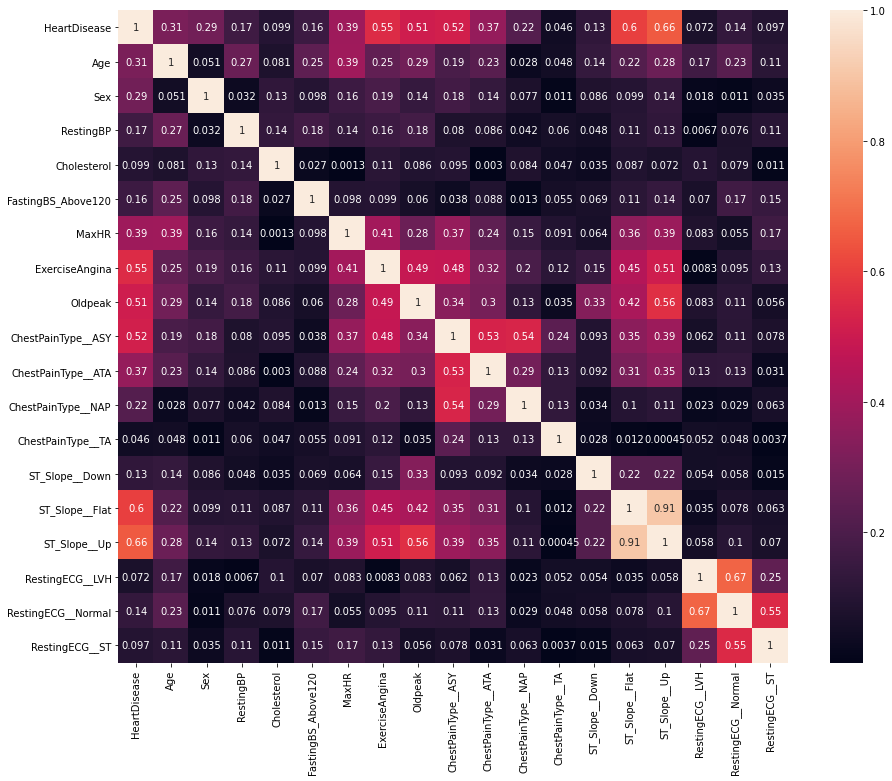

In [20]:
plt.figure(figsize=(15, 12))
sns.heatmap(prepared.corr().abs(),  annot=True)
plt.show()

# Testing
Model strength testing: AUROC and Recall (because false negatives are more important than false positives)